In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from geopy.distance import geodesic
import shapely.speedups
from tqdm import tqdm
from quetzal.model import stepmodel
from quetzal.engine import connectivity

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the transport network.
## Saves aggregated bus and short-distance rail network.
## Needs PT networks.

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [3]:
# Loading StepModel with PT networks...
sm = stepmodel.read_json(input_path + 'de_pt_network')
bus = stepmodel.read_json(input_path + 'de_pt_network_bus')

## Test links and nodes for network integrity
Neccessary for any further steps

In [4]:
# Check nodeset integrity for later steps to work
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    print('Found {} orphan nodes'.format(len(sm.orphan_nodes)))
    sm.nodes.drop(sm.orphan_nodes, inplace=True)
    # Test integrity again
    sm.integrity_test_nodeset_consistency()

Found 5 orphan nodes
no road_links or road_nodes


In [5]:
# Test sequences
# Use an own function because quetzal's takes ages
def test_sequences(trip):
    assert len(trip)==trip['link_sequence'].max(), \
        'broken sequence in trip {}'.format(trip['trip_id'].unique()[0])

In [6]:
# Fix sequences
# Use an own function because quetzal's takes ages
def fix_sequences(trip):
    trip = trip.sort_values('link_sequence')
    # Check link succession
    ind = list(trip.index)
    for i in range(len(trip.index) - 1):
        try:
            assert trip.loc[ind[i], 'b'] == trip.loc[ind[i+1], 'a'], \
                'broken trip {}: stop {} has no successor link'.format(
                    trip['trip_id'].unique()[0], trip.loc[ind[i], 'b'])
        except AssertionError:
            trip.loc[ind[i+1]:ind[-1], 'trip_id'] = \
                trip.loc[ind[i+1]:ind[-1], 'trip_id'] + '_' + str(i)
    # Repair sequences
    if len(trip) != trip['link_sequence'].max():
        trip['link_sequence'] = trip.groupby('trip_id')['link_sequence'].apply(
            lambda t: [j for j in range(1, len(t.index)+1)]).sum()
    return trip

In [7]:
# Test and save broken sequences
def test_sequences_save(trip):
    if len(trip)!=trip['link_sequence'].max():
        return list(trip.index)

In [8]:
tqdm.pandas()
try:
    sm.links.groupby('trip_id').progress_apply(test_sequences)
except AssertionError:
    links = sm.links.groupby('trip_id').progress_apply(fix_sequences).reset_index(level=0, drop=True)
    links.groupby('trip_id').progress_apply(test_sequences)
    sm.links = links

100%|██████████████████████████████████████████████████████████████████████████| 21118/21118 [00:07<00:00, 2650.10it/s]


In [9]:
broken_seqs = bus.links.groupby('trip_id').progress_apply(test_sequences_save)

100%|████████████████████████████████████████████████████████████████████████| 210028/210028 [01:24<00:00, 2478.78it/s]


In [10]:
broken_seqs.loc[broken_seqs.notna()]

trip_id
bus_1000218    [bus_2798066, bus_2798067, bus_2798068, bus_27...
bus_10004      [bus_134951, bus_134952, bus_134953, bus_13495...
bus_1003106    [bus_2802750, bus_2802751, bus_2802752, bus_28...
bus_1003982    [bus_2804123, bus_2804124, bus_2804125, bus_28...
bus_10068      [bus_135639, bus_135640, bus_135641, bus_13564...
                                     ...                        
bus_99702      [bus_729540, bus_729541, bus_729542, bus_72954...
bus_99879      [bus_730188, bus_730189, bus_730190, bus_73019...
bus_999762     [bus_2797494, bus_2797495, bus_2797496, bus_27...
bus_999928     [bus_2797641, bus_2797642, bus_2797643, bus_27...
bus_99996      [bus_730718, bus_730719, bus_730720, bus_73072...
Length: 2178, dtype: object

In [11]:
links = bus.links.loc[broken_seqs.loc[broken_seqs.notna()].sum()
                     ].groupby('trip_id').progress_apply(fix_sequences)

100%|██████████████████████████████████████████████████████████████████████████████| 2178/2178 [01:14<00:00, 29.31it/s]


In [12]:
links.sample()

,,route_id,route_type,a,b,time,trip_id,link_sequence,geometry
trip_id,index,,,,,,,,
bus_360398,bus_x_67374,bus_2425,bus,bus_n_x_426751,bus_n_x_134481,120.0,bus_360398_0_1_2,1,"LINESTRING (12.07247 50.90391, 12.06586 50.90802)"


In [13]:
links.shape

(63092, 8)

In [14]:
links.reset_index(level=0, drop=True, inplace=True)

In [15]:
links.groupby('trip_id').progress_apply(test_sequences)

100%|██████████████████████████████████████████████████████████████████████████| 36574/36574 [00:13<00:00, 2723.61it/s]


""


In [16]:
bus.links = bus.links.drop(broken_seqs.loc[broken_seqs.notna()].sum()).append(links)

In [17]:
bus.links.sample()

,route_id,route_type,a,b,time,trip_id,link_sequence,geometry
index,,,,,,,,
bus_2257152,bus_14843,bus,bus_n_280548,bus_n_351254,60.0,bus_684111,1,"LINESTRING (8.22199 50.64249, 8.22177 50.65140)"


In [18]:
bus.nodes.sample()

,stop_name,route_type,FID,geometry
index,,,,
bus_n_x_261573,Celle Jugenddorf / B3,bus,DE931,POINT (10.06721 52.58901)


In [19]:
sm.links.loc[sm.links.duplicated(['a', 'b', 'trip_id'], keep=False)]

,a,b,link_sequence,route_id,route_type,time,trip_id,geometry
index,,,,,,,,


## Map nodes to zones
Needed for clustering

In [20]:
# Nodes must be a GeoDataFrame
if 'FID' not in sm.nodes.columns:
    sm.nodes = gpd.GeoDataFrame(sm.nodes, crs=sm.epsg)
    shapely.speedups.enable()
    sm.nodes['FID'] = np.nan
    for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
        sm.nodes.loc[sm.nodes['geometry'].within(zone['geometry']), 'FID'] = zone['FID']

In [21]:
if 'FID' not in bus.nodes.columns:
    bus.nodes = gpd.GeoDataFrame(bus.nodes, crs=sm.epsg)
    bus.nodes['FID'] = np.nan
    for _, zone in tqdm(bus.zones.iterrows(), total=bus.zones.shape[0]):
        bus.nodes.loc[bus.nodes['geometry'].within(zone['geometry']), 'FID'] = zone['FID']

In [22]:
# Drop nodes outside of zones
sm.nodes = sm.nodes[sm.nodes['FID'].notna()]
bus.nodes = bus.nodes[bus.nodes['FID'].notna()]
print(sm.nodes.shape)
print(bus.nodes.shape)

(15376, 4)
(413611, 4)


## Divide links and nodes
Long-distance nodes don't need to be clustered due to relatively small numbers, while bus and rail short-distance services have a high geographic coverage.

In [23]:
# Divide nodes
print(sm.nodes.shape)
disagg_nodes = sm.nodes.loc[sm.nodes['route_type']=='rail_short_distance'].append(bus.nodes)
sm.nodes = sm.nodes.loc[sm.nodes['route_type']!='rail_short_distance']
print(disagg_nodes.shape)

(15376, 4)
(427624, 4)


In [24]:
# Divide links
print(sm.links.shape)
disagg_links = sm.links.loc[sm.links['route_type']=='rail_short_distance'].append(bus.links)
sm.links = sm.links.loc[sm.links['route_type']!='rail_short_distance']
print(disagg_links.shape)

(213129, 8)
(3391726, 8)


In [25]:
# Number of trips
len(disagg_links['trip_id'].unique())

259404

## Cluster stops
Bus and short-distance rail service in the GTFS feeds contain a lot of intermediate stops which can be clustered

In [27]:
# Cluster nodes by zone and route_type
nodes = []
parenthood = []
clusters = []
links = []
for z in tqdm(disagg_nodes['FID'].unique(), total=len(sm.zones)):
    for t in disagg_nodes.loc[disagg_nodes['FID']==z, 'route_type'].unique():
        n = disagg_nodes.loc[(disagg_nodes['route_type']==t) & (disagg_nodes['FID']==z)]
        n_clusters = min(5, max(1, len(sm.nodes.loc[ # Max 5, min 1 cluster
            (sm.nodes['FID']==z) & (sm.nodes['route_type'].isin(['rail_long_distance', 'air']))])))
        while n_clusters > len(n):
            n_clusters -= 1
        if n_clusters < 1:
            continue
        l, centroids, node_clusters, node_parenthood = connectivity.node_clustering(
            disagg_links.loc[(disagg_links['a'].isin(n.index)) &
                             (disagg_links['b'].isin(n.index))], n, n_clusters)
        nodes.append(centroids)
        parenthood.append(node_parenthood)
        clusters.append(node_clusters)
        links.append(l)

100%|███████████████████████████████████████████████████████████████████████████████▊| 466/467 [13:45<00:01,  1.77s/it]


<AxesSubplot:>

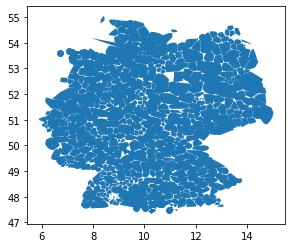

In [28]:
# Coverage
gpd.GeoDataFrame(pd.concat(clusters), crs=sm.epsg).plot()

In [29]:
# Number of zones with short-distance PT connection
len(pd.concat(parenthood)['FID'].unique())

466

In [35]:
# Merge node clusters by group (zone and route_type)
agg_nodes = []
for i in range(len(nodes)):
    agg = gpd.GeoDataFrame(nodes[i], crs=sm.epsg)
    agg.index = agg.index.astype(int)
    agg = agg.merge(parenthood[i][['FID', 'route_type', 'cluster']].drop_duplicates(),
        how='left', left_index=True, right_on='cluster')
    agg.index = agg['FID'] + '_' + agg['route_type'] + '_' + agg['cluster'].astype(str)
    agg_nodes.append(agg)

In [36]:
agg_nodes = gpd.GeoDataFrame(pd.concat(agg_nodes), crs=sm.epsg)
agg_nodes.sample(2)

,geometry,FID,route_type,cluster
DE144_rail_short_distance_1,POINT (9.94036 48.36634),DE144,rail_short_distance,1
DE715_1_rail_short_distance_0,POINT (8.74694 49.60993),DE715_1,rail_short_distance,0


In [37]:
print(agg_nodes.loc[agg_nodes['route_type']=='bus'].shape)
print(agg_nodes.loc[agg_nodes['route_type']!='bus'].shape)

(937, 4)
(918, 4)


### Aggregate links within the clustered trips

<AxesSubplot:>

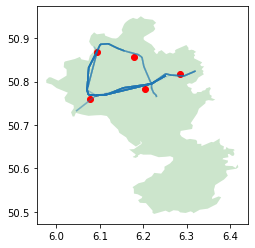

In [38]:
# Example: rail short-distance around Aachen
gpd.GeoDataFrame(links[0]).plot(alpha=.1,ax=gpd.GeoDataFrame(nodes[0]).plot(
    color='r', ax=gpd.GeoDataFrame(sm.zones.loc['DEA2D']).T.plot(color='g', alpha=.2)))

In [39]:
def aggregate_links(links, parents):
    links = links.sort_values(['trip_id', 'link_sequence'])
    l = links.loc[links['a']!=links['b']].copy()
    if len(l) == 0:
        return # Cluster is fully irrelevant
    # Correct geometry
    c_dict = parents.groupby('cluster').head(1).set_index(
        'cluster')['geometry_centroid'].to_dict()
    l['geometry'] = [geometry.LineString([c_dict[int(a)], c_dict[int(b)]])
                     for a, b in zip(l['a'], l['b'])]
    # Set a distance
    l['length'] = l['geometry'].apply(lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))
    # Aggregate time
    def within_time(trip):
        ident = trip['trip_id'].unique()[0]
        times = []
        prev_seq = 0
        for seq in trip['link_sequence']:
            times.append(int(links.loc[
                (links['link_sequence']>prev_seq) &
                (links['link_sequence']<=seq) &
                (links['trip_id']==ident), 'time'].sum()))
            prev_seq = seq
        l.loc[l['trip_id']==ident, 'time'] = times
    l.groupby('trip_id').apply(within_time)
    # Rename a and b as in agg_nodes
    prefix = parents['FID'].unique()[0] + '_' + parents['route_type'].unique()[0] + '_'
    l['a'] = prefix + l['a']
    l['b'] = prefix + l['b']
    return l

In [40]:
agg_links = []
for i in tqdm(range(len(links)), total=len(links)):
    l = aggregate_links(links[i], parenthood[i])
    if l is not None:
        agg_links.append(l)

100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [05:26<00:00,  2.85it/s]


<AxesSubplot:>

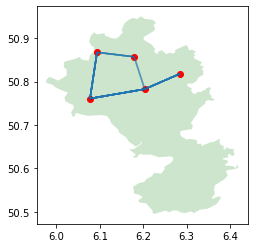

In [41]:
# Example: rail short-distance around Aachen
gpd.GeoDataFrame(agg_links[0]).plot(
    alpha=.1,ax=gpd.GeoDataFrame(nodes[0]).plot(
        color='r', ax=gpd.GeoDataFrame(sm.zones.loc['DEA2D']).T.plot(color='g', alpha=.2)))

In [42]:
agg_links = pd.concat(agg_links)
agg_links.drop(['disaggregated_a', 'disaggregated_b'], axis=1, inplace=True)
agg_links.sample(2)

,a,b,geometry,link_sequence,route_id,route_type,time,trip_id,length
index,,,,,,,,,
bus_215346,DEA52_bus_4,DEA52_bus_0,LINESTRING (7.435995814837234 51.4755481266402...,3.0,bus_8473,bus,222.0,bus_17450,9223
bus_1771536,DE232_bus_1,DE232_bus_0,"LINESTRING (12.0807260039303 49.0143551100709,...",13.0,bus_5737,bus,660.0,bus_447111,6700


In [43]:
len(agg_links)

73086

### Prepare the inter-zonal links

In [44]:
# Filter inter-zonal links
links = pd.concat(links)
parenthood = pd.concat(parenthood)
disagg_links = disagg_links.drop(links.index)
len(disagg_links)

102008

In [45]:
disagg_links = disagg_links.loc[(disagg_links['a'].isin(parenthood.index)) &
                                (disagg_links['b'].isin(parenthood.index))]
len(disagg_links)

101168

In [46]:
# Generate dictionary with old and new node indexes
parenthood['node_name'] = parenthood['FID'] + '_' + \
    parenthood['route_type'] + '_' + parenthood['cluster'].astype(str)
node_dict = parenthood['node_name'].to_dict()

In [47]:
# Replace old node indexes with new ones
disagg_links['a'] = disagg_links['a'].map(node_dict)
disagg_links['b'] = disagg_links['b'].map(node_dict)

In [48]:
# Any issues?
disagg_links.loc[disagg_links['a']==disagg_links['b']]

,a,b,geometry,link_sequence,route_id,route_type,time,trip_id
index,,,,,,,,


In [49]:
# Correct geometry
geo_dict = parenthood.groupby('node_name').head(1).set_index(
    'node_name')['geometry_centroid'].to_dict()
disagg_links['geometry'] = [geometry.LineString([geo_dict[a], geo_dict[b]])
                            for a,b in zip(disagg_links['a'], disagg_links['b'])]

In [50]:
# Add length
disagg_links['length'] = disagg_links['geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))

In [51]:
disagg_links.sample()

,a,b,geometry,link_sequence,route_id,route_type,time,trip_id,length
index,,,,,,,,,
rail_short_170323,DE21L_rail_short_distance_0,DE212_rail_short_distance_1,LINESTRING (11.25595192086744 47.9903202288146...,5.0,rail_short_17,rail_short_distance,660.0,rail_short_51826,26095


<AxesSubplot:>

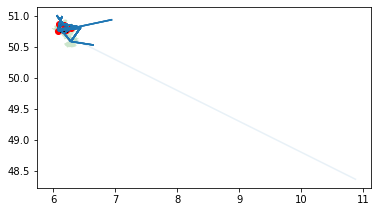

In [77]:
# Example: rail short-distance around Aachen
gpd.GeoDataFrame(disagg_links.loc[disagg_links['b'].isin(agg_nodes.loc[agg_nodes['FID']=='DEA2D'].index)]).plot(
    ax=gpd.GeoDataFrame(agg_links.loc[agg_links['a'].isin(agg_nodes.loc[agg_nodes['FID']=='DEA2D'].index)]).plot(
        alpha=.1,ax=gpd.GeoDataFrame(nodes[0]).plot(
            color='r', ax=gpd.GeoDataFrame(sm.zones.loc['DEA2D']).T.plot(color='g', alpha=.2))))

In [53]:
# Concat links
agg_links = pd.concat([agg_links, disagg_links])
len(agg_links)

174254

In [54]:
# Re-index sequence numbers
agg_links = agg_links.sort_values(['trip_id', 'link_sequence'])
agg_links['link_sequence'] = sum([list(range(1, count+1)) for count in
                                  agg_links.groupby('trip_id').count()['a']], [])

## Merge aggregated links and nodes with the model

In [55]:
# Generate length for long-distance nodes
sm.links['length'] = sm.links['geometry'].apply(
    lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))

In [56]:
# Re-add links to model
sm.links = sm.links.append(agg_links)
sm.links.shape

(206192, 9)

In [57]:
# Re-add nodes to the model
sm.nodes = sm.nodes.append(agg_nodes)
sm.nodes.shape

(3218, 5)

In [58]:
# Drop cluster column
sm.nodes.drop('cluster', axis=1, inplace=True)

In [59]:
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    print('Number of orphan nodes: {}'.format(
        len(sm.orphan_nodes)))
    print('Number of missing nodes: {}'.format(
        len(sm.missing_nodes)))

Number of orphan nodes: 0
Number of missing nodes: 3


In [60]:
sm.links.groupby('trip_id').apply(test_sequences)

""


In [61]:
len(sm.links.loc[sm.links.isna().any(axis=1)])

0

In [62]:
# Drop frequencies of unused nodes
sm.frequencies['stop_id'] = sm.frequencies['stop_id'].map(node_dict)
bus.frequencies['stop_id'] = bus.frequencies['stop_id'].map(node_dict)
sm.frequencies = sm.frequencies.loc[
    sm.frequencies['stop_id'].isin(sm.nodes.index)
].append(bus.frequencies.loc[
    bus.frequencies['stop_id'].isin(sm.nodes.index)
]).reset_index()
sm.frequencies = sm.frequencies.groupby(['hour', 'stop_id']).agg(
    {'trip_id': 'sum'}).reset_index()
sm.frequencies[['trip_id', 'hour']] = sm.frequencies[['trip_id', 'hour']].astype(int)

In [83]:
sm.frequencies.shape

(20687, 3)

In [64]:
# Drop routes of unused links
sm.pt_routes = sm.pt_routes.loc[sm.links['route_id'].unique()]
sm.pt_routes.shape

(8760, 9)

In [65]:
# Drop routes of unused bus links
bus.pt_routes = bus.pt_routes.loc[sm.links['route_id'].unique()]
bus.pt_routes.shape

(8760, 5)

## Save model


In [66]:
# Add bus service to ancilliary
sm.agencies = sm.agencies.append(bus.agencies).reset_index(drop=True)
sm.pt_routes = sm.pt_routes.append(bus.pt_routes).reset_index(drop=True)

In [67]:
# Now, we have bus services in the same tables
sm.pt_route_types.append('bus')

In [68]:
# Reduce file size by shortening node index names
sm.nodes['index'] = [i.replace('rail_short_distance', 'r_s') for i in sm.nodes.index]
sm.nodes.set_index('index', drop=True, inplace=True)
sm.links['a'] = sm.links['a'].apply(lambda n: n.replace('rail_short_distance', 'r_s'))
sm.links['b'] = sm.links['b'].apply(lambda n: n.replace('rail_short_distance', 'r_s'))

In [69]:
sm.nodes['index'] = [i.replace('rail_long_node', 'r_l_n') for i in sm.nodes.index]
sm.nodes.set_index('index', drop=True, inplace=True)
sm.links['a'] = sm.links['a'].apply(lambda n: n.replace('rail_long_node', 'r_l_n'))
sm.links['b'] = sm.links['b'].apply(lambda n: n.replace('rail_long_node', 'r_l_n'))

In [70]:
# Shorten link index names
sm.links['index'] = [i.replace('rail_long', 'r_l').replace('rail_short', 'r_s')
                     for i in sm.links.index]
sm.links.set_index('index', drop=True, inplace=True)

In [71]:
# Shorten route type names
type_dict = {'rail_short_distance': 'rail_short', 'rail_long_distance': 'rail_long'}
sm.links['route_type'] = sm.links['route_type'].replace(type_dict)
sm.nodes['route_type'] = sm.nodes['route_type'].replace(type_dict)
sm.pt_route_types = [t.replace('_distance', '') for t in sm.pt_route_types]

In [72]:
sm.links.loc[sm.links['route_type']=='rail_short'].sample()

,a,b,geometry,length,link_sequence,route_id,route_type,time,trip_id
index,,,,,,,,,
r_s_107255,DE145_1_r_s_0,DE146_r_s_0,LINESTRING (9.714546394305545 48.3162168927875...,25599,3.0,rail_short_33,rail_short,1080.0,rail_short_25637


In [73]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [74]:
sm.links.shape

(206192, 5)

In [ ]:
# Saving model...
sm.to_json(model_path + 'de_pt_network_agg',
           only_attributes=['zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')

In [85]:
sm.to_json(model_path + 'de_pt_network_ancillary',
           only_attributes=['agencies', 'pt_routes', 'frequencies'],
           encoding='utf-8')

to_hdf(overwriting): 100%|████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 178.39it/s]


In [76]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')